In [63]:
import pandas as pd
import numpy as np
from tabulate import tabulate

from sklearn.preprocessing import minmax_scale

pd.set_option('display.max_columns',15)
import sklearn.preprocessing as sk

import warnings
warnings.filterwarnings('ignore')

In [9]:
def preprocesProcedura(file):
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ['id', 'stimulusId', 'consistency', 'picture_sound_pos_neg', 'sound_number', 'picture_number','choose_type', 'not_processed_answer', 'answer_time', 'stimulus_time']
    answer=''
    # data.dropna()
    data = (data[['id', 'consistency', 'picture_sound_pos_neg', 'sound_number', 'picture_number', 'choose_type','not_processed_answer']].copy())
    data = data[data['consistency'] == 'inc']
    data = data[data['choose_type'] == 'emospace1']
    data = (data[['id', 'picture_sound_pos_neg', 'sound_number', 'picture_number', 'not_processed_answer']].copy())

    answer=data['not_processed_answer']
    answer_valence=[]
    answer_arousal=[]

    for i in answer:
        a=i[1:]
        a=a[:-1]
        a=a.split(', ',1)

        answer_valence.append(float(a[0]))
        answer_arousal.append(float(a[1]))


    answer_valance_scaled = minmax_scale(answer_valence, feature_range=(1,9))
    answer_arousal_scaled = minmax_scale(answer_arousal, feature_range=(1,9))

    data['answer_valence']=answer_valance_scaled
    data['answer_valence']=data['answer_valence'].astype("float")
    data['answer_arousal']=answer_arousal_scaled
    data['answer_arousal']=data['answer_arousal'].astype("float")

    pictures_data = preprocesPictures()
    sounds_data = preprocesSounds()


    # print(pictures_data)
    # print(pictures_data.dtypes)


    data = data.merge(sounds_data, on='sound_number')
    data = data.merge(pictures_data, on='picture_number')

    # data['picture_sound_pos_neg'] = data['picture_sound_pos_neg'].apply(lambda x : str(convert_to_pos_neg(x)))
    is_picture_pos = []
    is_sound_pos = []



    for i in data['picture_sound_pos_neg']:
        if i == "p+s-":
            is_picture_pos.append(1)
            is_sound_pos.append(0)
        else:
            is_picture_pos.append(0)
            is_sound_pos.append(1)

    data['is_picture_positive'] = is_picture_pos
    data['is_sound_positive'] = is_sound_pos

    data = (data[['id', 'sound_number', 'sound_valence_mean', 'sound_arousal_mean', 'is_sound_positive', 'is_sound_obscene',
                  'picture_number', 'picture_arousal_mean', 'picture_valence_mean', 'is_picture_positive', 'is_picture_obscene',
                  'not_processed_answer', 'answer_valence', 'answer_arousal']].copy())

    # print("PO JOINIE")
    #print(tabulate(data, headers='keys', tablefmt='psql'))
    #print(data.dtypes)

    return data


def preprocesPictures():
    data=pd.read_csv('IAPS.csv',sep=';')
    data = (data[['Description', 'IAPS', 'ValenceMean', 'ArousalMean']].copy())
    data.columns = ['is_picture_obscene', 'picture_number', 'picture_valence_mean', 'picture_arousal_mean']
    data['picture_number'] = data['picture_number'].apply(lambda x : x.replace(',', ''))
    data['picture_number'] = data['picture_number'].apply(lambda x : int(x))
    data['picture_valence_mean'] = data['picture_valence_mean'].apply(lambda x : x.replace(',', '.'))
    data['picture_arousal_mean'] = data['picture_arousal_mean'].apply(lambda x : x.replace(',', '.'))
    data['picture_valence_mean'] = data['picture_valence_mean'].apply(lambda x : float(x))
    data['picture_arousal_mean'] = data['picture_arousal_mean'].apply(lambda x : float(x))
    data['is_picture_obscene'] = data['is_picture_obscene'].apply(lambda  x : is_obscene(x))
    data['is_picture_obscene'] = data['is_picture_obscene'].astype("int")
    return data


def preprocesSounds():
    data = pd.read_csv('IADS2.csv', sep=';')
    data = (data[['Sound', 'Number', 'ValenceMean', 'ArousalMean']].copy())
    data.columns = ['is_sound_obscene', 'sound_number', 'sound_valence_mean', 'sound_arousal_mean']
    data['is_sound_obscene'] = data['is_sound_obscene'].apply(lambda  x : is_obscene(x))
    data['is_sound_obscene'] = data['is_sound_obscene'].astype("int")
    return data

def is_obscene(description):
    if description[:6] == 'Erotic' or description[0:4] == 'Nude':
        return '1'
    else:
        return '0'

def convert_to_pos_neg(pXsX):
    if pXsX == "p-s+":
        to_return = [-1,1]
        return to_return
    elif pXsX == "p+s-":
        to_return = [1,-1]
        return to_return
    else:
        return {0,2}


# print("PICTURES")
# preprocesPictures()
# print("SOUDS")
# preprocesSounds()



In [10]:
x = preprocesProcedura('procedura/1107_2019_Apr_19_0712.txt')
y = preprocesProcedura('procedura/1233_2019_Apr_16_1240.txt')

df = pd.concat([x, y], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 14 columns):
id                      61 non-null int64
sound_number            61 non-null int64
sound_valence_mean      61 non-null float64
sound_arousal_mean      61 non-null float64
is_sound_positive       61 non-null int64
is_sound_obscene        61 non-null int64
picture_number          61 non-null int64
picture_arousal_mean    61 non-null float64
picture_valence_mean    61 non-null float64
is_picture_positive     61 non-null int64
is_picture_obscene      61 non-null int64
not_processed_answer    61 non-null object
answer_valence          61 non-null float64
answer_arousal          61 non-null float64
dtypes: float64(6), int64(7), object(1)
memory usage: 6.8+ KB


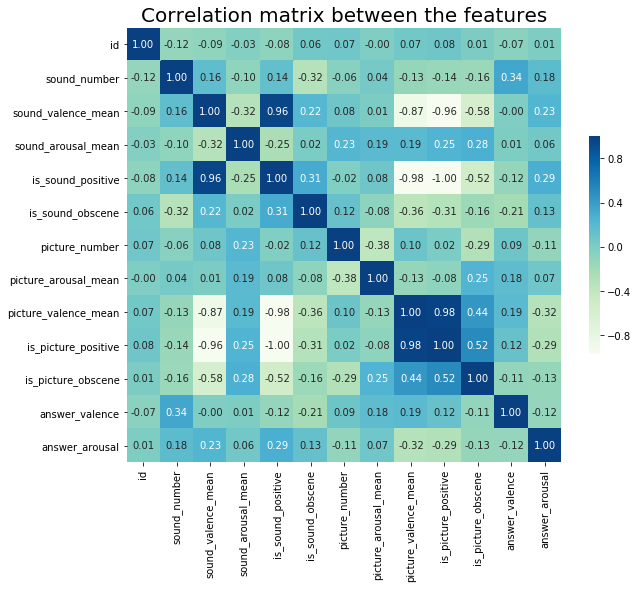

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True,fmt='.2f', cmap ='GnBu', cbar_kws={"shrink": .5}, robust=True)
plt.title('Correlation matrix between the features', fontsize=20)
plt.show()

In [12]:
#df = df.drop(['is_sound_positive', 'is_picture_positive', 'id'], axis=1)
print(df.columns)
all_features = ['sound_number', 'sound_valence_mean', 'sound_arousal_mean',
    'is_sound_obscene', 'picture_arousal_mean',
       'picture_valence_mean', 'picture_valence_mean', 'is_picture_positive',
       'is_picture_obscene']
target = ['answer_valence']

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=2)

Index(['id', 'sound_number', 'sound_valence_mean', 'sound_arousal_mean',
       'is_sound_positive', 'is_sound_obscene', 'picture_number',
       'picture_arousal_mean', 'picture_valence_mean', 'is_picture_positive',
       'is_picture_obscene', 'not_processed_answer', 'answer_valence',
       'answer_arousal'],
      dtype='object')


In [24]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
model = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=None) #fit intercept = false zwiekszylo

from sklearn.model_selection import cross_val_score
cv_result=cross_val_score(model, train[all_features], train[target],cv=10) 
print(cv_result.mean())

model.fit(train[all_features], train[target])
predicted = model.predict(test[all_features])

print("Mean squared error: %.2f"
      % mean_squared_error(test[target], predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test[target], predicted))

-21.479533237202027
0.4201679666178426
Mean squared error: 4.04
Variance score: 0.42


In [68]:
from sklearn.model_selection import GridSearchCV

def performLinearGridSearch(algo, params):
    clf = GridSearchCV(algo(), params, cv=5,
                   scoring='r2')
    clf.fit(train[all_features], train[target])

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    return clf.best_params_

In [69]:
def computeScore(y_test, y_pred):
    
    
    mse = mean_squared_error(y_test, y_pred)
    print("Mean squared error: %.2f"
      % mse)
    # Explained variance score: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Variance score: %.2f' % r2)
    return (mse, r2)

In [72]:
alphas = np.logspace(-5, 2, 30)

models_params = [(
    linear_model.LinearRegression, {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}), 
    (linear_model.Lasso, {'alpha': alphas, 'fit_intercept': [True, False]}), 
    (linear_model.ElasticNet, {'alpha': alphas, 'fit_intercept': [True, False]})]

for m,p in models_params:
    bp = performLinearGridSearch(m, p)
    if m == linear_model.LinearRegression:
        model = m(bp)
    else:
        model = linear_model.Lasso(alpha=0.0137, fit_intercept=True)
    
    model.fit(train[all_features], train[target])
    predicted = model.predict(test[all_features])
    computeScore(test[target], predicted)
    
    





Best parameters set found on development set:

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

Grid scores on development set:

0.095 (+/-0.620) for {'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.095 (+/-0.620) for {'copy_X': True, 'fit_intercept': True, 'normalize': False}
0.141 (+/-0.202) for {'copy_X': True, 'fit_intercept': False, 'normalize': True}
0.141 (+/-0.202) for {'copy_X': True, 'fit_intercept': False, 'normalize': False}
0.095 (+/-0.620) for {'copy_X': False, 'fit_intercept': True, 'normalize': True}
0.095 (+/-0.620) for {'copy_X': False, 'fit_intercept': True, 'normalize': False}
0.141 (+/-0.202) for {'copy_X': False, 'fit_intercept': False, 'normalize': True}
0.141 (+/-0.202) for {'copy_X': False, 'fit_intercept': False, 'normalize': False}

Mean squared error: 4.56
Variance score: 0.34
Best parameters set found on development set:

{'alpha': 0.013738237958832637, 'fit_intercept': True}

Grid scores on development set:

0.169 (+/-0.430) for {'a

In [73]:
alphas

array([1.00000000e-05, 1.74332882e-05, 3.03919538e-05, 5.29831691e-05,
       9.23670857e-05, 1.61026203e-04, 2.80721620e-04, 4.89390092e-04,
       8.53167852e-04, 1.48735211e-03, 2.59294380e-03, 4.52035366e-03,
       7.88046282e-03, 1.37382380e-02, 2.39502662e-02, 4.17531894e-02,
       7.27895384e-02, 1.26896100e-01, 2.21221629e-01, 3.85662042e-01,
       6.72335754e-01, 1.17210230e+00, 2.04335972e+00, 3.56224789e+00,
       6.21016942e+00, 1.08263673e+01, 1.88739182e+01, 3.29034456e+01,
       5.73615251e+01, 1.00000000e+02])